# Text features analysis

This Notebook aims to analyse to at the text features we will use to predict the tags. It also include the text ad `LDA` analysis to try to extract some informations of the text.

Note : For this part, we only use 10% of our data (Approx 200k rows, randomly sampled). Otherwise it was too long to run. We assume that the this sample is sufficient to describe the correlations of our words with the tags.

In [77]:
import os
os.chdir(os.environ['HOME'])

import stack_overflow_functions.DataLoader as data_loader
import stack_overflow_functions.DataTransformation as data_transfo
from pycountry_convert import country_name_to_country_alpha3
from pyspark.sql import SparkSession
from pyspark.sql import SparkSession
import patoolib
import gdown
# Import Spark NLP
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.sql.types import StructField, StructType, StringType

import pyspark
import sparknlp
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2
from geopy.geocoders import Nominatim
import pyspark.sql.functions as F
from pyspark.sql.types import LongType, StringType, IntegerType
import pandas as pd
import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import geopandas as gpd 
import matplotlib.pyplot as plt
import seaborn as sns
import json
seed = 2020

In [2]:
data_loader.download_data()

All the data folder already exists, we infer that you have already downloaded or extracted the data. If it is not the case delete the data folder (Data/sample) and re run this function.


'Done, data can be found at /home/loic/Data/sample.'

In [3]:
spark = sparknlp.start()
conf = (pyspark
        .SparkConf()
        .set("spark.ui.showConsoleProgress", "true")
       )
sc = pyspark.SparkContext.getOrCreate(conf=conf)
sqlcontext = pyspark.SQLContext(sc)

In [4]:
post_dir = "Data/sample/Posts"

In [5]:
%%time
posts = (sqlcontext
         .read
         .format("parquet")
         .option("header",True)
         .load(post_dir)
         .select("Id", "Body", "Tags")
         .sample(False,0.1)
        )
posts.count()

CPU times: user 28.7 ms, sys: 0 ns, total: 28.7 ms
Wall time: 2min 41s


209426

## Target : Splitting the tags

We already saw the tags distributions on part 1. We just re apply the splitting transformation to be able to use them.

In [6]:
tags_split = F.regexp_replace(
    F.regexp_replace(F.col('Tags'), '&lt;', ''), "&gt;", "<split_token>")
udf_drop = F.udf(lambda x: re.sub("'","",str(x[:-1])[1:-1]) if isinstance(x,list) else None)


posts = (
    posts
    .withColumn('Splitted_tags', tags_split)
    .withColumn('Splitted_tags', F.split(F.col("Splitted_tags"), "<split_token>"))
    .withColumn('Splitted_tags', udf_drop(F.col("Splitted_tags")))
    .withColumn('Splitted_tags', F.split(F.col("Splitted_tags"),","))
    .drop('Tags')
)

## Step 1 : Cleaning the text & visualize it
In order to clean the text we create a Pipeline with `spark NLP` transfomers to :
- Remove HTML tags and page review. We can easely think that those infomrations does not gather any information to predict the tags. We also remove the digits of the questions. 
- Lowercase text & remove stopwords. Again those information are negligible to understand the technology used in a post.
- Lemmatize the text. In our case it seems better to lemmatize instead of stemming since it would break piece of code usefull for the analysis.

All this steps will lead to a certain dimensionnality reduction we will show here.
### The pipeline

In [7]:
input_col = "Body"
clean_up_patterns = [
                    "p&gt;"
                    ,"&.*?;\space"
                    ,'&.*?;'                
                    ,"/.*?;"
                    ,"/code"
                    ,"/pre"
                    ,'/p'
                    ,"/a"
                    ,"href="
                    ,"lt;"
                    ,"gt;"
                    ,"[^\w\s]"
                    ,r"\b\d+\b"
                  ]


# Document assembler : Tokenize our text
documentAssembler = DocumentAssembler() \
    .setInputCol(input_col) \
    .setOutputCol('_intermediate_results')

# Document normalizer : Normalize the document
# by lowercasing, removing non utf8 chars
# and remove regex oattern defined
doc_norm = DocumentNormalizer() \
    .setInputCols("_intermediate_results") \
    .setOutputCol(input_col + "_cleaned") \
    .setAction("clean") \
    .setPatterns(clean_up_patterns) \
    .setReplacement(" ") \
    .setPolicy("pretty_all") \
    .setLowercase(True)

# Document tokenizer : allows to remove
# undesired tokens (punctuations etc.)
# prepare the colums for the stopwords 
# remover
tokenizer = Tokenizer() \
    .setInputCols([input_col + "_cleaned"]) \
    .setOutputCol("token") \
    .setSplitChars(['-']) \
    .setContextChars(['(', ')', '?', '!']) \
    .setSplitPattern("'") \
    .setMaxLength(0) \
    .setMaxLength(99999) \
    .setCaseSensitiveExceptions(False)


# StopWordsCleaner : remove 
# the stopwords based on
# a predifined list
Stop_words_cleaner = (
    StopWordsCleaner()
    .pretrained("stopwords_en", "en")
    .setInputCols(["token"])
    .setOutputCol(input_col + "_without_stopwords") 
    .setCaseSensitive(False) 
    .setLazyAnnotator(False)
)

# Lemmatize the text 
# thanks to the lemmatizing tab
# defined above
Lemmatizer_cleaner = (
    Lemmatizer() 
    .setInputCols([input_col + "_without_stopwords"]) 
    .setOutputCol(input_col + "_lemmatized") 
    .setDictionary("./Data/lemmatizer/AntBNC_lemmas_ver_001.txt", value_delimiter ="\t", key_delimiter = "->") 
    .setLazyAnnotator(False)
)


# Creates t
cleaning_pipeline = (
    Pipeline() 
    .setStages([
        documentAssembler,
        doc_norm,
        tokenizer,
        #Document_cleaner,
        Stop_words_cleaner,
        Lemmatizer_cleaner])
)


posts_lda = (
    cleaning_pipeline
    .fit(posts)
    .transform(posts)
    .select(F.col("Id"),
            F.col(input_col),
            F.col(input_col + "_lemmatized.result"),
            F.col("Splitted_tags")
           )
) 

posts_lda.persist(pyspark.StorageLevel.MEMORY_AND_DISK_2).count()

stopwords_en download started this may take some time.
Approximate size to download 2.9 KB
[OK!]


209426

### Visualisation of the dimension reduction (univariate)

In [8]:
distinct_words_lemma = (
  posts_lda
 .select(F.explode(F.col('result')).alias('word'))
 .filter(F.col("word") != "")
 .sample(False, 0.1, seed)
 .groupby('word')
 .count()
 .toPandas()
)

distinct_words_before = (
  posts_lda
 .select(F.split(F.col('Body'), '\s+').alias('split'))
 .select(F.explode(F.col('split')).alias('word'))
 .filter(F.col("word") != "")
 .sample(False, 0.1, seed)
 .groupby('word')
 .count()
 .toPandas()
)

print("Number of uniques words before cleaning : {}".format(distinct_words_before.shape[0]))
print("Number of uniques words after cleaning : {}".format(distinct_words_lemma.shape[0]))

Number of uniques words before cleaning : 679297
Number of uniques words after cleaning : 211926


In [9]:
print("Statistics about word distributions before the cleaning : ")
print(distinct_words_before['count'].describe())
print("\n ------------------------")
print("Statistics about word distributions after the cleaning : ")
print(distinct_words_lemma['count'].describe())

Statistics about word distributions before the cleaning : 
count    679297.000000
mean          4.671294
std         239.062538
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max      106218.000000
Name: count, dtype: float64
Statistics about word distributions after the cleaning : 
count    211926.000000
mean          9.949383
std         219.745358
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max       63399.000000
Name: count, dtype: float64


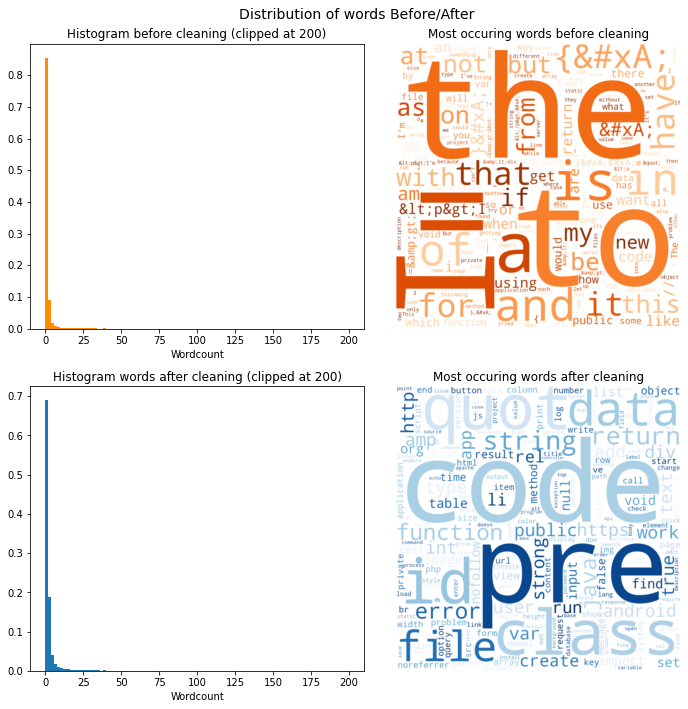

In [10]:
import numpy as np
options_wc = {"background_color":"white",
                "width":1600, 
                "height":1600}

weights_before = dict([(pair[0], np.log(pair[1])) for 
                       pair in distinct_words_before.sort_values(by="count",ascending=False).values])
weights_lemmas = dict([(pair[0], np.log(pair[1])) 
                       for pair in distinct_words_lemma.sort_values(by="count",ascending=False).values])


fig, axs = plt.subplots(2,2, figsize=(10,10))
plt.suptitle("Distribution of words Before/After",fontsize=14)

data=distinct_words_before['count']
axs[0][0].hist(data,bins=np.linspace(0,200,101),weights=np.zeros_like(data) + 1. /data.size,color='darkorange')
axs[0][0].set_title('Histogram before cleaning (clipped at 200)')
axs[0][0].set_xlabel("Wordcount")


data=distinct_words_lemma['count']
axs[1][0].hist(data,bins=np.linspace(0,200,101),weights=np.zeros_like(data) + 1. /data.size)
axs[1][0].set_title('Histogram words after cleaning (clipped at 200)')
axs[1][0].set_xlabel("Wordcount")


ax = axs[0][1]
wc = WordCloud(**options_wc,colormap = 'Oranges')
wc.generate_from_frequencies(weights_before)
ax.imshow(wc, interpolation='bilinear')
ax.set_title('Most occuring words before cleaning')
ax.axis('off')


ax = axs[1][1]
wc = WordCloud(**options_wc,colormap = 'Blues')
wc.generate_from_frequencies(weights_lemmas)
ax.imshow(wc, interpolation='bilinear')
ax.set_title('Most occuring words after cleaning')
ax.axis('off')
plt.tight_layout()

As expected, the cleaning worked succesfully: 
- We removed arround **70%** of the unique words
- The distribution of the words if a bit less concentrated arround 0.
- The most frequent words after cleaning is much more associated to programming than before. This last analysis is a bit personnal but we think most pepole would agree on it. 

One of the advantage of stack overflow questions is that the text is properly written by serious people thus it makes the cleaning smooth and "easy" (No particular expressions, not a lot of typo etc).
This cleaning will lead to a less sparse matrix for our TF-IDF transformation and make the clustering easier. 

### Visualisation of the 'correlation' between text & most occurring tags (bivariate)
It seems now important to see if we can see some discriminations between words and tags. As we saw in part 1 there are more than () unique tags. We cannot take a look one by one. Thus we will just take a look at the most frequent words for the 6 more frequent tags. 

In [11]:
most_occuring_tags = ["javascript", "java", "python", "c#", "android", "c++"] 

top = 10
windowSpec  = Window.partitionBy("language").orderBy(F.col("count").desc())


posts_lang = (
    posts_lda
    .withColumn("language",data_transfo.udf_detect_language(most_occuring_tags)(F.col('Splitted_tags')))
    .filter(F.col("language").isNotNull())
    .select("language", F.explode(F.col('result')).alias('word'))
    .filter(F.col("word") != "")
    .groupby('word',"language")
    .count()
    .withColumn("word_rank",row_number().over(windowSpec))
    .filter(F.col('word_rank') <= top)
    .toPandas()
        )

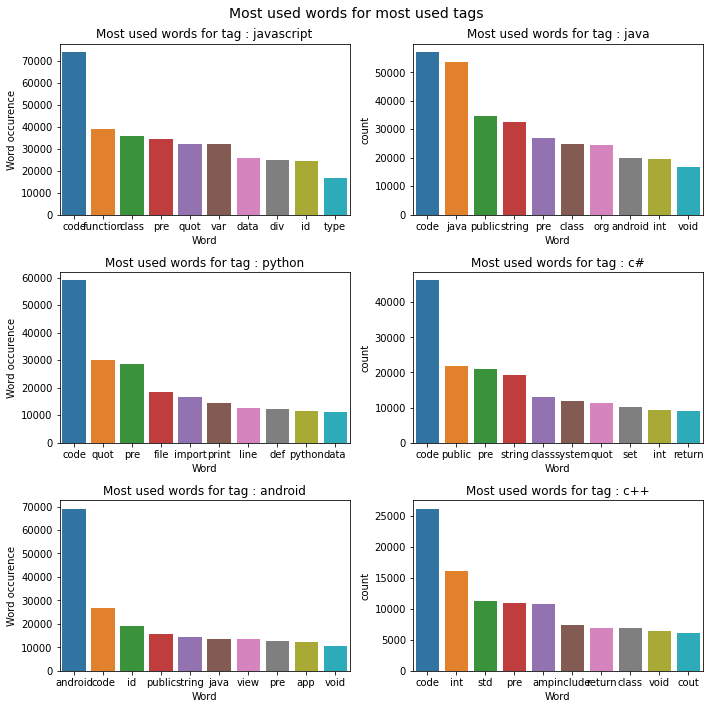

In [12]:
fig, axs = plt.subplots(3,2, figsize=(10,10))
plt.suptitle("Most used words for most used tags",fontsize=14)
i=0
j=0
for tag in most_occuring_tags:
    tmp = (posts_lang
           .loc[posts_lang["language"] == tag, :]
           .sort_values(by="count",ascending=False)
          )
    sns.barplot(x= "word", y="count",data=tmp,ax=axs[i][j], palette="viridis")
    axs[i][j].set_xlabel("Word")
    
    axs[i][j].set_title("Most used words for tag : " + tag)
    if j==1:
        j=0
        i+=1
    else:
        axs[i][j].set_ylabel("Word occurence")
        j+=1
plt.tight_layout()

As we can see the most frequent words related to each tags corresponds well to the frameword associated.
- For example the `python` tag have words like "import", "print", "line"
- We can also see that frameworks that are related like android & java have some redundant words. We hope it will help our multi label classfier.

### Clustering of the texts : LDA.
In this part we use Spark ML library to perform an LDA soft clustering on our questions. We choose the number of topics thanks to the log [perplexity](https://en.wikipedia.org/wiki/Perplexity) and likelihood of the model and see if the topics have some relation with the tags.

We use the ML library instead of the MLLIB one (RDD based) since it have much more interesting attributes for LDA.

In [50]:
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.mllib.linalg import Vector,Vectors
from pyspark.ml.clustering import LDA, LDAModel

We first start by vectorizing our documents using tf idf methods. We only take the 5000 most used words in order to create our document Matrix (25% of the unique words). We did not try a lot of combinations because of the time of computations.

In [59]:
n_top = 10 

# TF
cv = CountVectorizer(inputCol="result", outputCol="tf_features", vocabSize=5000, minDF=0)
cvmodel = cv.fit(posts_lda)
result_cv = cvmodel.transform(posts_lda)

# IDF
idf = IDF(inputCol="tf_features", outputCol="features")
idfModel = idf.fit(result_cv)
result_tfidf = idfModel.transform(result_cv) 

# LDA
lda = LDA(k=n_top, maxIter=20)
model = lda.fit(result_tfidf)

In [121]:
argmax = F.udf(lambda x: int(np.argmax(np.array(x))),IntegerType())
w = Window.partitionBy("topic").orderBy(F.col("count").desc())
results_lda = (
    model
    .transform(result_tfidf)
    .withColumn("topic", argmax(F.col("topicDistribution")))
    .select(F.explode("Splitted_tags").alias('Tag'),"topic")
    .groupby("Tag","topic")
    .count()
    .withColumn("rank_tag", row_number().over(w))
    .filter(F.col("rank_tag") <= 10)
    .toPandas()
)

In [123]:
# extract vocabulary from CountVectorizer
vocab = cvmodel.vocabulary
topics = model.describeTopics()   
topics_rdd = topics.rdd
topics_words = (
    topics_rdd
    .map(lambda row: row['termIndices'])
    .map(lambda idx_list: [vocab[idx] for idx in idx_list])
    .collect()
)
for idx, topic in enumerate(topics_words):
    tmp = results_lda[results_lda['topic'] == idx]
    tmp["word"] = topic
    tmp = (tmp[["word","Tag"]]
           .rename({"word" : "Most occurent word",
                   "Tag" : "Most occurent Tags"})
          )
    print("Topic: {} top ten words and tags associated.".format(idx))    
    print("*"*40)
    print("\n")
    print(tmp)
    print("\n")
    print("*"*40)
    

Topic: 0 top ten words and tags associated.
****************************************


        word            Tag
90   request     javascript
91       app            php
92    server             c#
93       php        android
94  function           java
95      http         python
96      user  ruby-on-rails
97  response         jquery
98   message            ios
99      file        node.js


****************************************
Topic: 1 top ten words and tags associated.
****************************************


        word           Tag
0       quot    javascript
1        var           ios
2      react         swift
3        map            c#
4  component   objective-c
5      state       reactjs
6       prop       reactjs
7      const        iphone
8       cell   uitableview
9       text   objective-c


****************************************
Topic: 2 top ten words and tags associated.
****************************************


      word         Tag
80      na        java
81

The results are not stunning. The problem is that pyspark has no metric to evaluate the LDA coherence. see [this post](https://stackoverflow.com/questions/63967860/get-the-recommended-number-of-topics-from-an-lda-model-using-pyspark-ml) 